In [20]:
from matplotlib import animation
from phi.tf.flow import *
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

import os, sys, logging, argparse, pickle, glob, \
                    random, distutils.dir_util


phi.__version__


# math.backend.set_global_default_backend(64)
# backend.default_backend()

'2.2.0'

In [21]:
fname_train = 'plume_train.pickle'

with open(fname_train, 'rb') as f: 
  data_preloaded = pickle.load(f)
  
print("Loaded data, {} training sims".format(len(data_preloaded)))


Loaded data, 6 training sims


In [22]:
# # low res domain
# resolution = dict(y=64, x=64)

# simulation_lenght = 100

# x_bound = simulation_lenght
# y_bound = 2 * simulation_lenght

# domain2x = dict(**resolution, bounds=Box['y, x', 0:x_bound, 0:y_bound])

# d2x = CenteredGrid(0, extrapolation=extrapolation.BOUNDARY,  **domain2x)
# v2x = StaggeredGrid(1, extrapolation=extrapolation.ZERO, **domain2x) 


# v = field.read('/home/sayem/Desktop/Notebook/PhiFlow/velo_001000.npz')
# v = v.at(v2x)
# v.shape

In [23]:
class Dataset():
    def __init__(self, data_preloaded, num_frames, \
        num_sims=None, batch_size=1, is_testset=False):
        self.epoch         = None
        self.epochIdx      = 0
        self.batch         = None
        self.batchIdx      = 0
        self.step          = None
        self.stepIdx       = 0

        self.dataPreloaded = data_preloaded
        self.batchSize     = batch_size

        self.numSims       = num_sims
        self.numBatches    = num_sims // batch_size
        self.numFrames     = num_frames
        self.numSteps      = num_frames
        
        # initialize directory keys (using naming scheme from SoL codebase)
        # constant additional per-sim channel: Reynolds numbers 
        # from data generation hard coded for training and test data here
        if not is_testset:
            self.dataSims = ['plume-fdt-hires-set_1/sim_%06d'%i for i in range(num_sims) ]
            # NU = [10**(-i-1) for i in range(num_sims)]
            # NU = [2* 10**(-i-1) for i in range(num_sims)]
            ReNrs = [160000.0, 320000.0, 640000.0,  1280000.0,  2560000.0,  5120000.0]
            # print(NU)
            self.extConstChannelPerSim = { self.dataSims[i]:[ReNrs[i]] for i in range(num_sims) }
        else:
            self.dataSims = ['plume-fdt-hires-testset_1/sim_%06d'%i for i in range(num_sims) ]
            # NU = [2* 10**(-i-1) for i in range(num_sims)]
            ReNrs = [120000.0, 480000.0, 1920000.0, 7680000.0] 
            # print(NU)
            self.extConstChannelPerSim = { self.dataSims[i]:[ReNrs[i]] for i in range(num_sims) }

        self.dataFrames = [ np.arange(num_frames) for _ in self.dataSims ]  

        # # debugging example, check shape of a single marker density field:
        # print(format(self.dataPreloaded[self.dataSims[0]][0][0].shape )) 
        # print(format(self.dataPreloaded[self.dataSims[0]][0][1].shape )) 
        # print(format(self.dataPreloaded[self.dataSims[0]][0][2].shape )) 
        
        # the data has the following shape ['sim', frame, field (dens/vel)] 
        # where each field is [batch-size, y-size, x-size, channels]
        self.resolution = self.dataPreloaded[self.dataSims[0]][0][0]
        # print(type(self.resolution))
        self.resolution = self.dataPreloaded[self.dataSims[0]][0][0].shape[1:3]  

        assert len(self.dataPreloaded[self.dataSims[0]][0][0].shape)==3, 'Data shape is wrong.'
        assert len(self.dataPreloaded[self.dataSims[0]][0][1].shape)==3, 'Data shape is wrong.'
        assert len(self.dataPreloaded[self.dataSims[0]][0][2].shape)==3, 'Data shape is wrong.'

        # print(self.resolution)

        # compute data statistics for normalization
        self.dataStats = {
            'std': (
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][0].reshape(-1)) for asim in \
                    self.dataSims for i in range(num_frames)], axis=-1)), # density
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][1].reshape(-1)) for asim in \
                    self.dataSims for i in range(num_frames)], axis=-1)), # x-velocity
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][2].reshape(-1)) for asim \
                    in self.dataSims for i in range(num_frames)], axis=-1)), # y-velocity
            )
        }
        self.dataStats.update({
            'ext.std': [ np.std([np.absolute(self.extConstChannelPerSim[asim][0]) \
                for asim in self.dataSims]) ] # Reynolds Nr
        })

        
        if not is_testset:
            print("Data stats: "+format(self.dataStats))


    # re-shuffle data for next epoch
    def newEpoch(self, exclude_tail=0, shuffle_data=True):
        self.numSteps = self.numFrames - exclude_tail
        simSteps = [ (asim, self.dataFrames[i][0:(len(self.dataFrames[i])-exclude_tail)]) \
            for i,asim in enumerate(self.dataSims) ]
        sim_step_pair = []
        for i,_ in enumerate(simSteps):
            sim_step_pair += [ (i, astep) for astep in simSteps[i][1] ]  # (sim_idx, step) ...

        if shuffle_data: random.shuffle(sim_step_pair)
        self.epoch = [ list(sim_step_pair[i*self.numSteps:(i+1)*self.numSteps]) \
            for i in range(self.batchSize*self.numBatches) ]
        self.epochIdx += 1
        self.batchIdx = 0
        self.stepIdx = 0

    def nextBatch(self):  
        self.batchIdx += self.batchSize
        self.stepIdx = 0

    def nextStep(self):
        self.stepIdx += 1


In [24]:
# for class Dataset():
def getData(self, consecutive_frames):
    d_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][0]
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    u_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][1]
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    v_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][2]
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    ext = [
        self.extConstChannelPerSim[
            self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]]
        ][0] for i in range(self.batchSize)
    ]
    return [d_hi, u_hi, v_hi, ext]

In [25]:
nsims = 6
batch_size = 3
simsteps = (599-101)+1

simulation_length = 200.

msteps = 4

LR = 1e-4
EPOCHS = 15

# dataset = Dataset(data_preloaded=data_preloaded, \
#     num_frames=simsteps, num_sims=nsims, batch_size=batch_size )

In [26]:

dataset = Dataset(data_preloaded=data_preloaded, \
    num_frames=simsteps, num_sims=nsims, batch_size=batch_size )

Data stats: {'std': (0.6699216, 2.0487106, 3.3298407), 'ext.std': [1732512.6262166172]}


In [27]:
class Plume():
    def __init__(self, domain):

        self.INFLOW = CenteredGrid(Sphere(y=20, x=simulation_length//2, radius=15), **domain)

    def step(self, velocity, density, re, res, dt=0.02, buoyancy_factor=0.5):
        # viscosity
        NU = 1.0/re*dt*res*(res/2) # diffusivity
        velocity = diffuse.explicit(velocity, NU, dt)
        # velocity = diffuse.explicit(field=velocity, diffusivity=1.0/re*dt*res*(res/2), dt=dt)

        # advection 
        density = advect.semi_lagrangian(density, velocity, dt) + self.INFLOW
        buoyancy_force = (density * (buoyancy_factor, 0)).at(velocity)
        velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
        # velocity = diffuse.explicit(velocity, NU, dt)

        # mass conservation (pressure solve)
        velocity, _ = fluid.make_incompressible(velocity) # , obstacles)

        return [density, velocity]

In [28]:
def to_keras(dens_vel_grid_array, ext_const_channel):
    # align the sides the staggered velocity grid making its size the same as the centered grid
    return math.stack(
        [
            math.pad(dens_vel_grid_array[1].vector['x'].values, \
                {'x':(0, 1)} , math.extrapolation.ZERO),
            # dens_vel_grid_array[1].vector['y'].y[:-1].values,           # v
            math.pad(dens_vel_grid_array[1].vector['y'].values, \
                {'y':(0, 1)} , math.extrapolation.ZERO),
            math.ones(dens_vel_grid_array[0].shape) * ext_const_channel  # Re
        ],
        math.channel('channels')
    )


# def to_keras(dens_vel_grid_array, ext_const_channel):
#     # drop the unused edges of the staggered velocity grid making its dim same to the centered grid's
#     with tf.name_scope('to_feature') as scope:
#         return math.stack(
#             [
#                 dens_vel_grid_array[1].vector['x'].x[:-1].values,         # u
#                 dens_vel_grid_array[1].vector['y'].y[:-1].values,         # v
#                 math.ones(dens_vel_grid_array[0].shape)*ext_const_channel # Re
#             ],
#             math.channel('channels')
#         )


# def to_keras(dens_vel_grid_array, ext_const_channel):
#     # align the sides the staggered velocity grid making its size the same as the centered grid
#     return math.stack(
#         [
#             math.pad( dens_vel_grid_array[1].vector['x'].values, {'x':(0,1)} , math.extrapolation.ZERO),
#             dens_vel_grid_array[1].vector['y'].y[:-1].values,         # v
#             math.ones(dens_vel_grid_array[0].shape)*ext_const_channel # Re
#         ],
#         math.channel('channels')
#     )


# def to_phiflow(tf_tensor):
#     print(type(tf_tensor[...,:-1, 1]))
#     a =  StaggeredGrid(
#         math.stack(
#             [
#                 math.tensor(tf.pad(tf_tensor[..., 1], [(0,0), (0,1), (0,0)]), \
#                     math.batch('batch'), math.spatial('y, x')), # v
#                 # math.tensortf.pad((tf_tensor[..., 1], [(0,0), (0,0), (0,1)]),\
#                 #     math.batch('batch'), math.spatial('y, x')), # v
#                 # math.tensor(tf.pad(tf_tensor[...,:-1, 0], [(0,1), (0,0), (0,0)]),\
#                 #     math.batch('batch'), math.spatial('y, x')), # u 
#                 math.tensor( tf_tensor[...,:-1, 0], \
#                     math.batch('batch'), math.spatial('y, x')), # u
#             ],  math.channel('vector')
#         )
#     )
#     # print(a.shape)
#     return a

In [29]:
# one of the most crucial! how many simulation steps to look into the future while training
# msteps = 4

# # this is the actual resolution in terms of cells
source_res = list(dataset.resolution)
print(source_res)
# # this is a virtual size, in terms of abstract units for the bounding box 
# of the domain (it's important for conversions or when rescaling to physical units)
# simulation_length = 100.

resolution = dict(y=source_res[0], x=source_res[1])


# print(type(simulation_lenght))

x_bound = simulation_length
y_bound = 2 * simulation_length


domain = dict(**resolution, bounds=Box['y, x', 0:y_bound, 0:x_bound])
# domain = dict(y=source_res[0], x=source_res[1], bounds=Box['x, y', 0:2*simulation_length, \
#              0:simulation_length])

simulator = Plume(domain=domain)

[64, 32]


In [30]:
def network_small(inputs_dict):
    l_input = keras.layers.Input(**inputs_dict)
    block_0 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_input)
    block_0 = keras.layers.LeakyReLU()(block_0)

    l_conv1 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_0)
    l_conv1 = keras.layers.LeakyReLU()(l_conv1)
    l_conv2 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv1)
    block_1 = keras.layers.LeakyReLU()(l_conv2)

    l_output = keras.layers.Conv2D(filters=2,  kernel_size=5, padding='same')(block_1) # u, v
    return keras.models.Model(inputs=l_input, outputs=l_output, name='Small_Network')


In [31]:
def network_medium(inputs_dict):
    l_input = keras.layers.Input(**inputs_dict)
    block_0 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_input)
    block_0 = keras.layers.LeakyReLU()(block_0)

    l_conv1 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_0)
    l_conv1 = keras.layers.LeakyReLU()(l_conv1)
    l_conv2 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv1)
    l_skip1 = keras.layers.add([block_0, l_conv2])
    block_1 = keras.layers.LeakyReLU()(l_skip1)

    l_conv3 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_1)
    l_conv3 = keras.layers.LeakyReLU()(l_conv3)
    l_conv4 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv3)
    l_skip2 = keras.layers.add([block_1, l_conv4])
    block_2 = keras.layers.LeakyReLU()(l_skip2)

    l_conv5 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_2)
    l_conv5 = keras.layers.LeakyReLU()(l_conv5)
    l_conv6 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv5)
    l_skip3 = keras.layers.add([block_2, l_conv6])
    block_3 = keras.layers.LeakyReLU()(l_skip3)

    l_conv7 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_3)
    l_conv7 = keras.layers.LeakyReLU()(l_conv7)
    l_conv8 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv7)
    l_skip4 = keras.layers.add([block_3, l_conv8])
    block_4 = keras.layers.LeakyReLU()(l_skip4)

    l_conv9 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_4)
    l_conv9 = keras.layers.LeakyReLU()(l_conv9)
    l_convA = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv9)
    l_skip5 = keras.layers.add([block_4, l_convA])
    block_5 = keras.layers.LeakyReLU()(l_skip5)

    l_output = keras.layers.Conv2D(filters=2,  kernel_size=5, padding='same')(block_5)
    return keras.models.Model(inputs=l_input, outputs=l_output, name='mediuml_Network')

In [32]:
network = network_small(dict(shape=(source_res[0], source_res[1], 3)))
network.summary()
opt = tf.keras.optimizers.Adam(learning_rate=LR) 

Model: "Small_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 32, 32)        2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 32, 32)        25632     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 32, 32)        25632     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 32, 32)      

In [33]:
def to_phiflow(tf_tensor, domain):
    # print("Input tensor shape")
    # print(tf_tensor.shape)
    # print("Input tensor shape")
    # resolution2x = dict(y=64, x=32)
    # domain2x = dict(**resolution2x, bounds=Box['y, x', 0:200, 0:100])
    a =  StaggeredGrid(
        math.stack(
            [
                math.tensor(tf_tensor[...,:-1, :, 1], math.batch('batch'), \
                        math.spatial('y, x')), # v
                math.tensor(tf_tensor[...,:-1, 0], \
                    math.batch('batch'), math.spatial('y, x')), # u 
            ],  math.channel('vector')
        ), **domain
    )
    # print('%%%%% a shape %%%%%%%')
    # print("y vctor: ", a.vector['y'])
    # print("x vector: ", a.vector['x'])
    # print("Grid: ", a)
    # print('%%%%% a shape %%%%%%%')
    return a

# x = tf.random.uniform(shape=(3, 64, 32, 2), minval=1, maxval=5, dtype=tf.int32)

# a = to_phiflow(x)

# '''
#     Let's take a velocity =  StaggeredGrid[(batchᵇ=3, yˢ=64, xˢ=32, vectorᶜ=y,x), size=(y=200.000, x=100.000), extrapolation=0]
#     which has two components: 
#     velocity.vector['y'] =  CenteredGrid[(batchᵇ=3, yˢ=63, xˢ=32), size=(y=196.875, x=100.000), extrapolation=0]
#     velocity.vector['x'] =  CenteredGrid[(batchᵇ=3, yˢ=64, xˢ=31), size=(y=200.000, x=96.875), extrapolation=0]

# '''

# x = velocity + a will raise error IncompatibleShapes: Cannot merge shapes [(batchᵇ=3, yˢ=63, xˢ=32), (batchᵇ=3, yˢ=65, xˢ=32)] because dimension 'y' exists with different sizes.

In [34]:
# tf_tensor = x
# print(tf_tensor[...,1].shape)
# z = tf_tensor[...,1]
# print(z.shape)
# print(z[...,:-1,:].shape)
# # (3, 63, 32)
# t = tf.pad(tf_tensor[...,1], [(0,0), (0,0), (0,0)])
# t.shape

In [35]:
# tf_tensor[...,:-1, 0].shape

In [36]:
def training_step(dens_gt, vel_gt, Re, i_step):
    with tf.GradientTape() as tape:
        prediction, correction = [ [ dens_gt[0], vel_gt[0] ] 
                                 ], [0] # predicted states with correction, 
                                        # inferred velocity corrections
        # print('===========from training step prediction[-1]============')
        # print(prediction[-1])
        # print('============from training step prediction[-1]===========')
        for i in range(msteps):
            prediction += [simulator.step(
                          density=prediction[-1][0], 
                          velocity=prediction[-1][1], 
                          res = source_res[0],
                          re = Re,
                          dt = 0.5
                        )
            ] # prediction: [[density1, velocity1], [density2, velocity2], ...]
            # print('prediction[-1]===!!===')
            # print(math.pad(prediction[-1][1].vector['x'].values, \
            #     {'x':(0, 1)} , math.extrapolation.ZERO))
            # print(math.pad(prediction[-1][1].vector['y'].values, \
            #     {'y':(0, 1)} , math.extrapolation.ZERO))
            # print('prediction[-1]===!!===')
            # print("++++++++++")
            # print("Passed")
            # print("++++++++++")
            model_input = to_keras(prediction[-1], Re)
            # print("+++++model_input+++++")
            # print('model_input')
            # print(model_input)
            # print("+++++model_input+++++")

            model_input /= math.tensor([dataset.dataStats['std'][1], dataset.dataStats['std'][2], \
                dataset.dataStats['ext.std'][0]], channel('channels')) # [u, v, Re]
            # print("+++++model_input /+++++")
            # print(model_input)
            # print("+++++model_input /+++++")
            # # print("========!!!!!=========")
            # # print(model_input.native(['batch', 'y', 'x', 'channels']))
            # # print("========!!!!!=========")
            model_out = network(model_input.native(['batch', 'y', 'x', 'channels']), training=True)
            # print("+++++model_out+++++")
            # print("model_out")
            # print("++++++model_out++++")
            model_out *= [dataset.dataStats['std'][1], dataset.dataStats['std'][2]] # [u, v]
            # print('========ModelOut *=========')
            # print(model_out)
            # print('========ModelOut *=========')
            # # # print('========to_phiflow=========')
            # # # # print(to_phiflow(model_out))
            # # # print('========to_phiflow=========')
            correction += [ to_phiflow(model_out, domain) ]  # [velocity_correction1, velocity_correction2, ...]
            # print('========Correction[-1]=========') 
            # print(correction[-1][0])
            # print(correction[-1][1])
            # print('========Correction[-1]=========')
            
            # print('========Prediction[-1][1]=========')
            # print("v velocity prediction: ", prediction[-1][1].vector['y'])
            # print("u velocity prediction: ", prediction[-1][1].vector['x'])
            # print("Velocity prediction: ", prediction[-1][1])

            # print('========Prediction[-1][1]=========')
            # vis.plot(correction[-1])
            prediction[-1][1] = prediction[-1][1] + correction[-1]
            # ## prediction[-1][1] = correction[-1]
            # print('========After Prediction[-1]=========')
            # print(prediction[-1][1])
            # print('========After Prediction[-1]=========')

        # evaluate loss
        loss_steps_x = [
            tf.nn.l2_loss(
                (
                    vel_gt[i].vector['x'].values.native(('batch', 'y', 'x'))
                    - prediction[i][1].vector['x'].values.native(('batch', 'y', 'x'))
                ) / dataset.dataStats['std'][1]
            )
            for i in range(1, msteps+1)
        ]
        loss_steps_x_sum = tf.math.reduce_sum(loss_steps_x)

        loss_steps_y = [
            tf.nn.l2_loss(
                (
                    vel_gt[i].vector['y'].values.native(('batch', 'y', 'x'))
                    - prediction[i][1].vector['y'].values.native(('batch', 'y', 'x'))
                ) / dataset.dataStats['std'][2]
            )
            for i in range(1, msteps+1)
        ]
        loss_steps_y_sum = tf.math.reduce_sum(loss_steps_y)

        loss = (loss_steps_x_sum + loss_steps_y_sum)/msteps

        gradients = tape.gradient(loss, network.trainable_variables)
        opt.apply_gradients(zip(gradients, network.trainable_variables))

        return math.tensor(loss)    

In [37]:
training_step_jit = math.jit_compile(training_step)

In [38]:
# LR = 1e-4
# EPOCHS = 15

# opt = tf.keras.optimizers.Adam(learning_rate=LR) 

# optional, load existing network...
# set to epoch nr. to load existing network from there
resume = 0
if resume>0: 
    ld_network = keras.models.load_model('./nn_epoch{:04d}.h5'.format(resume)) 
    #ld_network = keras.models.load_model('./nn_final.h5') # or the last one
    network.set_weights(ld_network.get_weights())

In [39]:
steps = 0
for j in range(EPOCHS):  # training
    dataset.newEpoch(exclude_tail=msteps)
    if j<resume:
        print('resume: skipping {} epoch'.format(j+1))
        steps += dataset.numSteps*dataset.numBatches
        continue

    for ib in range(dataset.numBatches):   
        for i in range(dataset.numSteps):
            # resolution2x = dict(y=64, x=32)
            # domain2x = dict(**resolution2x, bounds=Box['y, x', 0:200, 0:100])
            # d2x = CenteredGrid(0, extrapolation=extrapolation.BOUNDARY,  **domain2x)
            # v2x = StaggeredGrid(0, extrapolation=extrapolation.ZERO, **domain2x) 

            # batch: [[dens0, dens1, ...], [x-velo0, x-velo1, ...], [y-velo0, y-velo1, ...], [ReynoldsNr(s)]]            
            batch = getData(dataset, consecutive_frames=msteps)
            # print(batch[3])
            # print('Batch passed\n')
            dens_gt = [   # [density0:CenteredGrid, density1, ...]
                # domain.scalar_grid(
                #     math.tensor(batch[0][k], math.batch('batch'), math.spatial('y, x'))
                CenteredGrid(
                    math.tensor(batch[0][k], math.batch('batch'), math.spatial('y, x')),
                    **domain
                ) for k in range(msteps+1)
            ]
            # print('dens_gt\n')
            # print(dens_gt[-1])
            # print(dens_gt[-1].shape)
            # vis.plot(dens_gt[-1])
            # break
            vel_gt = [   # [velocity0:StaggeredGrid, velocity1, ...]
                # domain.staggered_grid(
                StaggeredGrid(
                    math.stack(
                        [
                            math.tensor(batch[2][k], math.batch('batch'), math.spatial('y, x')),
                            math.tensor(batch[1][k], math.batch('batch'), math.spatial('y, x')),
                        ],  math.channel(vector='y, x')
                    ), **domain
                ) for k in range(msteps+1)
            ]
            # # print('velo passed\n')
            # print(vel_gt)
            # vis.plot(vel_gt[-1])
            # break
            re_nr = math.tensor(batch[3], math.batch('batch'))
            # print(math.batch('batch'))
            # print(f"{re_nr:dtype:.6f}")
            # dens_gt, vel_gt, Re, i_step
            loss = training_step_jit(dens_gt, vel_gt, re_nr, math.tensor(steps)) 
            # loss = training_step(dens_gt, vel_gt, re_nr, steps) 
            
            steps += 1
            if (j==0 and ib==0 and i<3) or (j==0 and ib==0 and i%128==0) or (j>0 and ib==0 and i==400): # reduce output 
              print('epoch {:03d}/{:03d}, batch {:03d}/{:03d}, step {:04d}/{:04d}: loss={}'.format( j+1, \
                            EPOCHS, ib+1, dataset.numBatches, i+1, dataset.numSteps, loss ))
            
            dataset.nextStep()
        # break
        dataset.nextBatch()

    if j%10==9: 
        network.save('./h5/set_4_nn_epoch{:04d}.h5'.format(j+1))

# all done! save final version
network.save('./h5/set_4_nn_final.h5'); print("Training done, saved NN")


epoch 001/015, batch 001/002, step 0001/0495: loss=1002.4807
epoch 001/015, batch 001/002, step 0002/0495: loss=560.08124
epoch 001/015, batch 001/002, step 0003/0495: loss=398.42163
epoch 001/015, batch 001/002, step 0129/0495: loss=79.6539
epoch 001/015, batch 001/002, step 0257/0495: loss=115.282486
epoch 001/015, batch 001/002, step 0385/0495: loss=162.12546
epoch 002/015, batch 001/002, step 0401/0495: loss=47.476906
epoch 003/015, batch 001/002, step 0401/0495: loss=45.27552
epoch 004/015, batch 001/002, step 0401/0495: loss=43.796112
epoch 005/015, batch 001/002, step 0401/0495: loss=35.978733
epoch 006/015, batch 001/002, step 0401/0495: loss=30.138634
epoch 007/015, batch 001/002, step 0401/0495: loss=28.291569
epoch 008/015, batch 001/002, step 0401/0495: loss=41.059
epoch 009/015, batch 001/002, step 0401/0495: loss=25.858183
epoch 010/015, batch 001/002, step 0401/0495: loss=26.286554
epoch 011/015, batch 001/002, step 0401/0495: loss=23.872234
epoch 012/015, batch 001/002,

In [41]:
fname_train = 'plume_test.pickle'

with open(fname_train, 'rb') as f: 
  data_test_preloaded = pickle.load(f)
  
print("Loaded data, {} training sims".format(len(data_test_preloaded)))



Loaded data, 4 training sims


In [48]:
dataset_test = Dataset( data_preloaded=data_test_preloaded, \
    is_testset=True, num_frames=simsteps, num_sims=4, batch_size=4 )

# we only need 1 batch with t=0 states to initialize the test simulations with
dataset_test.newEpoch(shuffle_data=False)
batch = getData(dataset_test, consecutive_frames=0) 

re_nr_test = math.tensor(batch[3], math.batch('batch')) # Reynolds numbers
print(f"Reynolds numbers in test data set: " +format(re_nr_test))

Reynolds numbers in test data set: (120000.000, 480000.000, 1920000.000, 7680000.000) along batchᵇ


In [49]:
# source_dens_initial = math.tensor( batch[0][0], math.batch('batch'), math.spatial('y, x'))

# resolution2x = dict(y=64, x=32)
# domain2x = dict(**resolution2x, bounds=Box['y, x', 0:200, 0:100])
# d2x = CenteredGrid(0, extrapolation=extrapolation.BOUNDARY,  **domain2x)
# v2x = StaggeredGrid(0, extrapolation=extrapolation.ZERO, **domain2x) 

source_dens_initial = CenteredGrid(math.tensor( batch[0][0], \
    math.batch('batch'), math.spatial('y, x')), **domain)


source_vel_initial = StaggeredGrid(phi.math.stack([
            math.tensor(batch[2][0], math.batch('batch'),math.spatial('y, x')),
            math.tensor(batch[1][0], math.batch('batch'),math.spatial('y, x'))], 
            math.channel(vector='y, x')
        ), 
        **domain
    )

In [50]:
# source_dens_initial

In [51]:
# print(source_vel_initial.vector['x'])
# print(source_vel_initial.vector['y'])
# print(source_vel_initial)

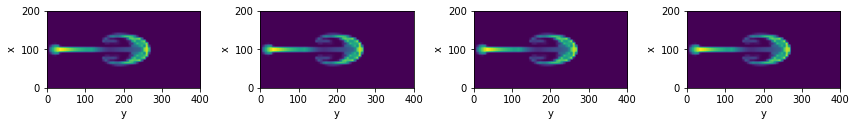

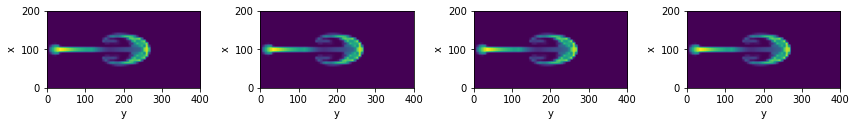

In [52]:
vis.plot(source_dens_initial, show_color_bar=False)

In [53]:
source_dens_test, source_vel_test = source_dens_initial, source_vel_initial
steps_source = [[source_dens_test, source_vel_test]]

# note - math.jit_compile() not useful for numpy solve... hence not necessary
for i in range(simsteps):
    [source_dens_test, source_vel_test] = simulator.step(
        density=source_dens_test,
        velocity=source_vel_test,
        res = source_res[0],
        re=math.tensor(re_nr_test),
        dt=0.5
    )
    steps_source.append( [source_dens_test, source_vel_test] )

print("Source simulation steps "+format(len(steps_source)))

Source simulation steps 500


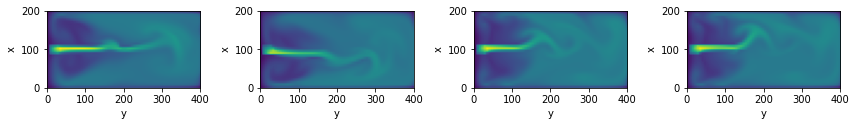

In [54]:
vis.plot(steps_source[-1][0], show_color_bar=False);

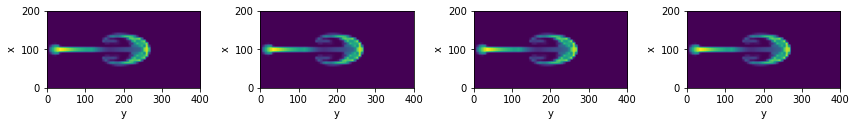

In [55]:
source_dens_test, source_vel_test = source_dens_initial, source_vel_initial
steps_hybrid = [[source_dens_test, source_vel_test]]
vis.plot(steps_hybrid[-1][0], size=(12, 9), show_color_bar=False);

In [56]:
source_dens_test, source_vel_test = source_dens_initial, source_vel_initial
steps_hybrid = [[source_dens_test, source_vel_test]]
        
for i in range(simsteps):
    [source_dens_test, source_vel_test] = simulator.step(
        density=source_dens_test,
        velocity=source_vel_test,
        res = source_res[0],
        re=math.tensor(re_nr_test),
        dt=0.5
    )
    model_input = to_keras([source_dens_test, source_vel_test], re_nr_test )
    model_input /= math.tensor([dataset.dataStats['std'][1], dataset.dataStats['std'][2], \
        dataset.dataStats['ext.std'][0]], channel('channels')) # [u, v, Re]
    model_out = network(model_input.native(['batch', 'y', 'x', 'channels']), training=False)
    model_out *= [dataset.dataStats['std'][1], dataset.dataStats['std'][2]] # [u, v]
    correction =  to_phiflow(model_out, domain)
    # print(correction)
    # print("==========")
    # print(source_vel_test)
    # print("++++++++++++")
    source_vel_test = source_vel_test + correction

    steps_hybrid.append( [source_dens_test, source_vel_test] )
    
print("Steps with hybrid solver "+format(len(steps_hybrid)))

Steps with hybrid solver 500


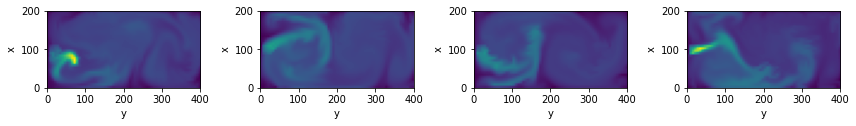

In [57]:
vis.plot(steps_hybrid[-1][0], size=(12, 9), lib='matplotlib', show_color_bar=False);

MAE for source: 5.787335395812988 , and hybrid: 12.20337200164795


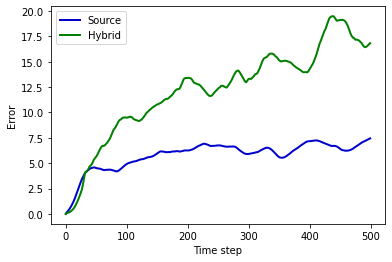

In [58]:
import pylab
b = 0 # batch index for the following comparisons

errors_source, errors_pred = [], []

for index in range(simsteps):
  vx_ref = dataset_test.dataPreloaded[ dataset_test.dataSims[b] ][ index ][1][0,...]
  vy_ref = dataset_test.dataPreloaded[ dataset_test.dataSims[b] ][ index ][2][0,...]
  vxs = vx_ref - steps_source[index][1].values.vector[1].numpy('batch,y,x')[b,...]
  vxh = vx_ref - steps_hybrid[index][1].values.vector[1].numpy('batch,y,x')[b,...]
  vys = vy_ref - steps_source[index][1].values.vector[0].numpy('batch,y,x')[b,...] 
  vyh = vy_ref - steps_hybrid[index][1].values.vector[0].numpy('batch,y,x')[b,...] 
  errors_source.append(np.mean(np.abs(vxs)) + np.mean(np.abs(vys))) 
  errors_pred.append(np.mean(np.abs(vxh)) + np.mean(np.abs(vyh)))

fig = pylab.figure().gca()
pltx = np.linspace(0, simsteps, simsteps)
fig.plot(pltx, errors_source, lw=2, color='mediumblue', label='Source')  
fig.plot(pltx, errors_pred,   lw=2, color='green', label='Hybrid')
pylab.xlabel('Time step'); pylab.ylabel('Error'); fig.legend()

print("MAE for source: "+format(np.mean(errors_source)) +" , and hybrid: "+format(np.mean(errors_pred)) )